In [2]:
import pandas as pd
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import time

# 1. Data collection


In [3]:
df = pd.read_csv('result.csv')
df_transfer = pd.read_csv('player_transfer_values.csv')
df = df[df['Minutes'] > 900]
df_transfer['Player'] = df_transfer['Player'].replace('Igor Júlio', 'Igor')
df = pd.merge(df, df_transfer[['Player', 'Transfer Value']], how = 'left', on = ['Player']).dropna().reset_index(drop = True)
df = df.replace('N/a', pd.NaT)

# 2. Statistics  


In [4]:
print('Shape of data:', df.shape)

df.head(5)  

Shape of data: (302, 79)


,Player,Nation,Team,Position,Age,Matches Played,Starts,Minutes,Goals,Assists,...,Possession PrgR,Fls,Fld,Off,Crs,Recov,Won,Miscellaneous Stats Lost,Won%,Transfer Value
0,Aaron Ramsdale,ENG,Southampton,GK,26-355,27,27,2430,0,0,...,0,1,4,0,0,20,5,0,100.0,€18.7M
1,Aaron Wan-Bissaka,ENG,West Ham,DF,27-159,32,31,2794,2,2,...,139,22,24,4,64,155,22,29,43.1,€26.9M
2,Abdoulaye Doucouré,MLI,Everton,MF,32-123,30,29,2425,3,1,...,91,46,5,10,23,139,29,43,40.3,€5.8M
3,Adam Armstrong,ENG,Southampton,"FW,MF",28-083,20,15,1248,2,2,...,79,12,5,9,14,23,5,9,35.7,€15.1M
4,Adam Smith,ENG,Bournemouth,DF,34-005,22,17,1409,0,0,...,31,15,11,0,30,43,12,13,48.0,€1.5M


In [5]:
df.info()
# Most nul value feature: Penalty Kicks Save%, CS%, Save%, GA90, SoT%, G/sh, Dist, Succ%, Tkld%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 79 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Player                     302 non-null    object 
 1   Nation                     302 non-null    object 
 2   Team                       302 non-null    object 
 3   Position                   302 non-null    object 
 4   Age                        302 non-null    object 
 5   Matches Played             302 non-null    int64  
 6   Starts                     302 non-null    int64  
 7   Minutes                    302 non-null    int64  
 8   Goals                      302 non-null    int64  
 9   Assists                    302 non-null    int64  
 10  Yellow Cards               302 non-null    int64  
 11  Red Cards                  302 non-null    int64  
 12  Expected Goals             302 non-null    float64
 13  Expedted Assist Goals      302 non-null    float64

In [6]:
obj = (df.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Total numbers of categorical features:", len(object_cols))
print(object_cols)

Total numbers of categorical features: 17
['Player', 'Nation', 'Team', 'Position', 'Age', 'GA90', 'Save%', 'CS%', 'Penalty Kicks Save%', 'SoT%', 'G/sh', 'Dist', 'Long Pass completion', 'Succ%', 'Tkld%', 'Won%', 'Transfer Value']


In [7]:
df.describe()

,Matches Played,Starts,Minutes,Goals,Assists,Yellow Cards,Red Cards,Expected Goals,Expedted Assist Goals,PrgC,...,Dis,Rec,Possession PrgR,Fls,Fld,Off,Crs,Recov,Won,Miscellaneous Stats Lost
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,...,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,27.175497,22.473510,1980.695364,2.920530,2.168874,4.105960,0.122517,2.890066,2.151987,37.274834,...,18.672185,787.036424,71.284768,21.748344,21.307947,3.374172,34.827815,83.427152,26.029801,25.569536
std,5.880792,7.474272,629.823041,4.145242,2.542912,2.585809,0.357487,3.590820,2.091871,33.911953,...,16.254674,367.832371,72.712411,13.936600,15.221112,4.642258,41.934177,42.008143,23.515227,19.680170
min,11.000000,8.000000,903.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,132.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000
25%,23.000000,16.000000,1444.500000,0.000000,0.000000,2.000000,0.000000,0.600000,0.500000,12.000000,...,5.000000,519.000000,8.000000,12.000000,10.000000,0.000000,4.000000,50.000000,9.000000,12.000000
50%,29.000000,23.000000,2002.000000,1.000000,1.000000,4.000000,0.000000,1.450000,1.500000,28.000000,...,16.500000,720.500000,53.000000,20.000000,18.000000,2.000000,14.000000,77.000000,18.500000,21.000000
75%,32.000000,28.750000,2480.000000,4.000000,3.000000,6.000000,0.000000,3.875000,3.100000,55.750000,...,27.750000,953.500000,107.750000,29.000000,30.000000,4.000000,54.750000,108.750000,35.750000,34.000000
max,35.000000,35.000000,3150.000000,28.000000,18.000000,12.000000,2.000000,23.900000,12.800000,189.000000,...,88.000000,2132.000000,425.000000,67.000000,99.000000,27.000000,191.000000,197.000000,127.000000,123.000000


In [8]:
null_percent = df.isnull().sum() / df.shape[0] * 100
null_percent_sorted = null_percent.sort_values(ascending=False)
null_percent_sorted

Penalty Kicks Save%         93.377483
GA90                        92.384106
CS%                         92.384106
Save%                       92.384106
Dist                         6.953642
                              ...    
Recov                        0.000000
Won                          0.000000
Miscellaneous Stats Lost     0.000000
Won%                         0.000000
Transfer Value               0.000000
Length: 79, dtype: float64

# 3. Data preprocessing 


In [9]:
# drop outliner
df = df[df['Player'] != 'Mohamed Salah']

# missing data
df = df.drop(columns = ['Player', 'GA90', 'Save%', 'CS%', 'Penalty Kicks Save%'])
columns_to_fill = ['Succ%', 'Tkld%', 'G/sh', 'Dist', 'SoT%']
for col in columns_to_fill:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(df[col].mean())

# convert age and transfer value
df['Age'] = df['Age'].apply(lambda x : float(f'{(int(x.split('-')[0]) + (int(x.split('-')[1]) / 365)):.2f}'))
df['Transfer Value'] = df['Transfer Value'].apply(lambda x : float(x[1:len(x) - 1:]))

df = df.astype({
    'Long Pass completion' : 'float',
    'Won%' : 'float'
})

# convert categorical to numerical feature
le_nation = LabelEncoder()
df['Nation'] = le_nation.fit_transform(df['Nation'])

le_team = LabelEncoder()
df['Team'] = le_team.fit_transform(df['Team'])

df = df.drop(columns = 'Position')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301 entries, 0 to 301
Data columns (total 73 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Nation                     301 non-null    int64  
 1   Team                       301 non-null    int64  
 2   Age                        301 non-null    float64
 3   Matches Played             301 non-null    int64  
 4   Starts                     301 non-null    int64  
 5   Minutes                    301 non-null    int64  
 6   Goals                      301 non-null    int64  
 7   Assists                    301 non-null    int64  
 8   Yellow Cards               301 non-null    int64  
 9   Red Cards                  301 non-null    int64  
 10  Expected Goals             301 non-null    float64
 11  Expedted Assist Goals      301 non-null    float64
 12  PrgC                       301 non-null    int64  
 13  PrgP                       301 non-null    int64  
 14 

# 4. Data visualization


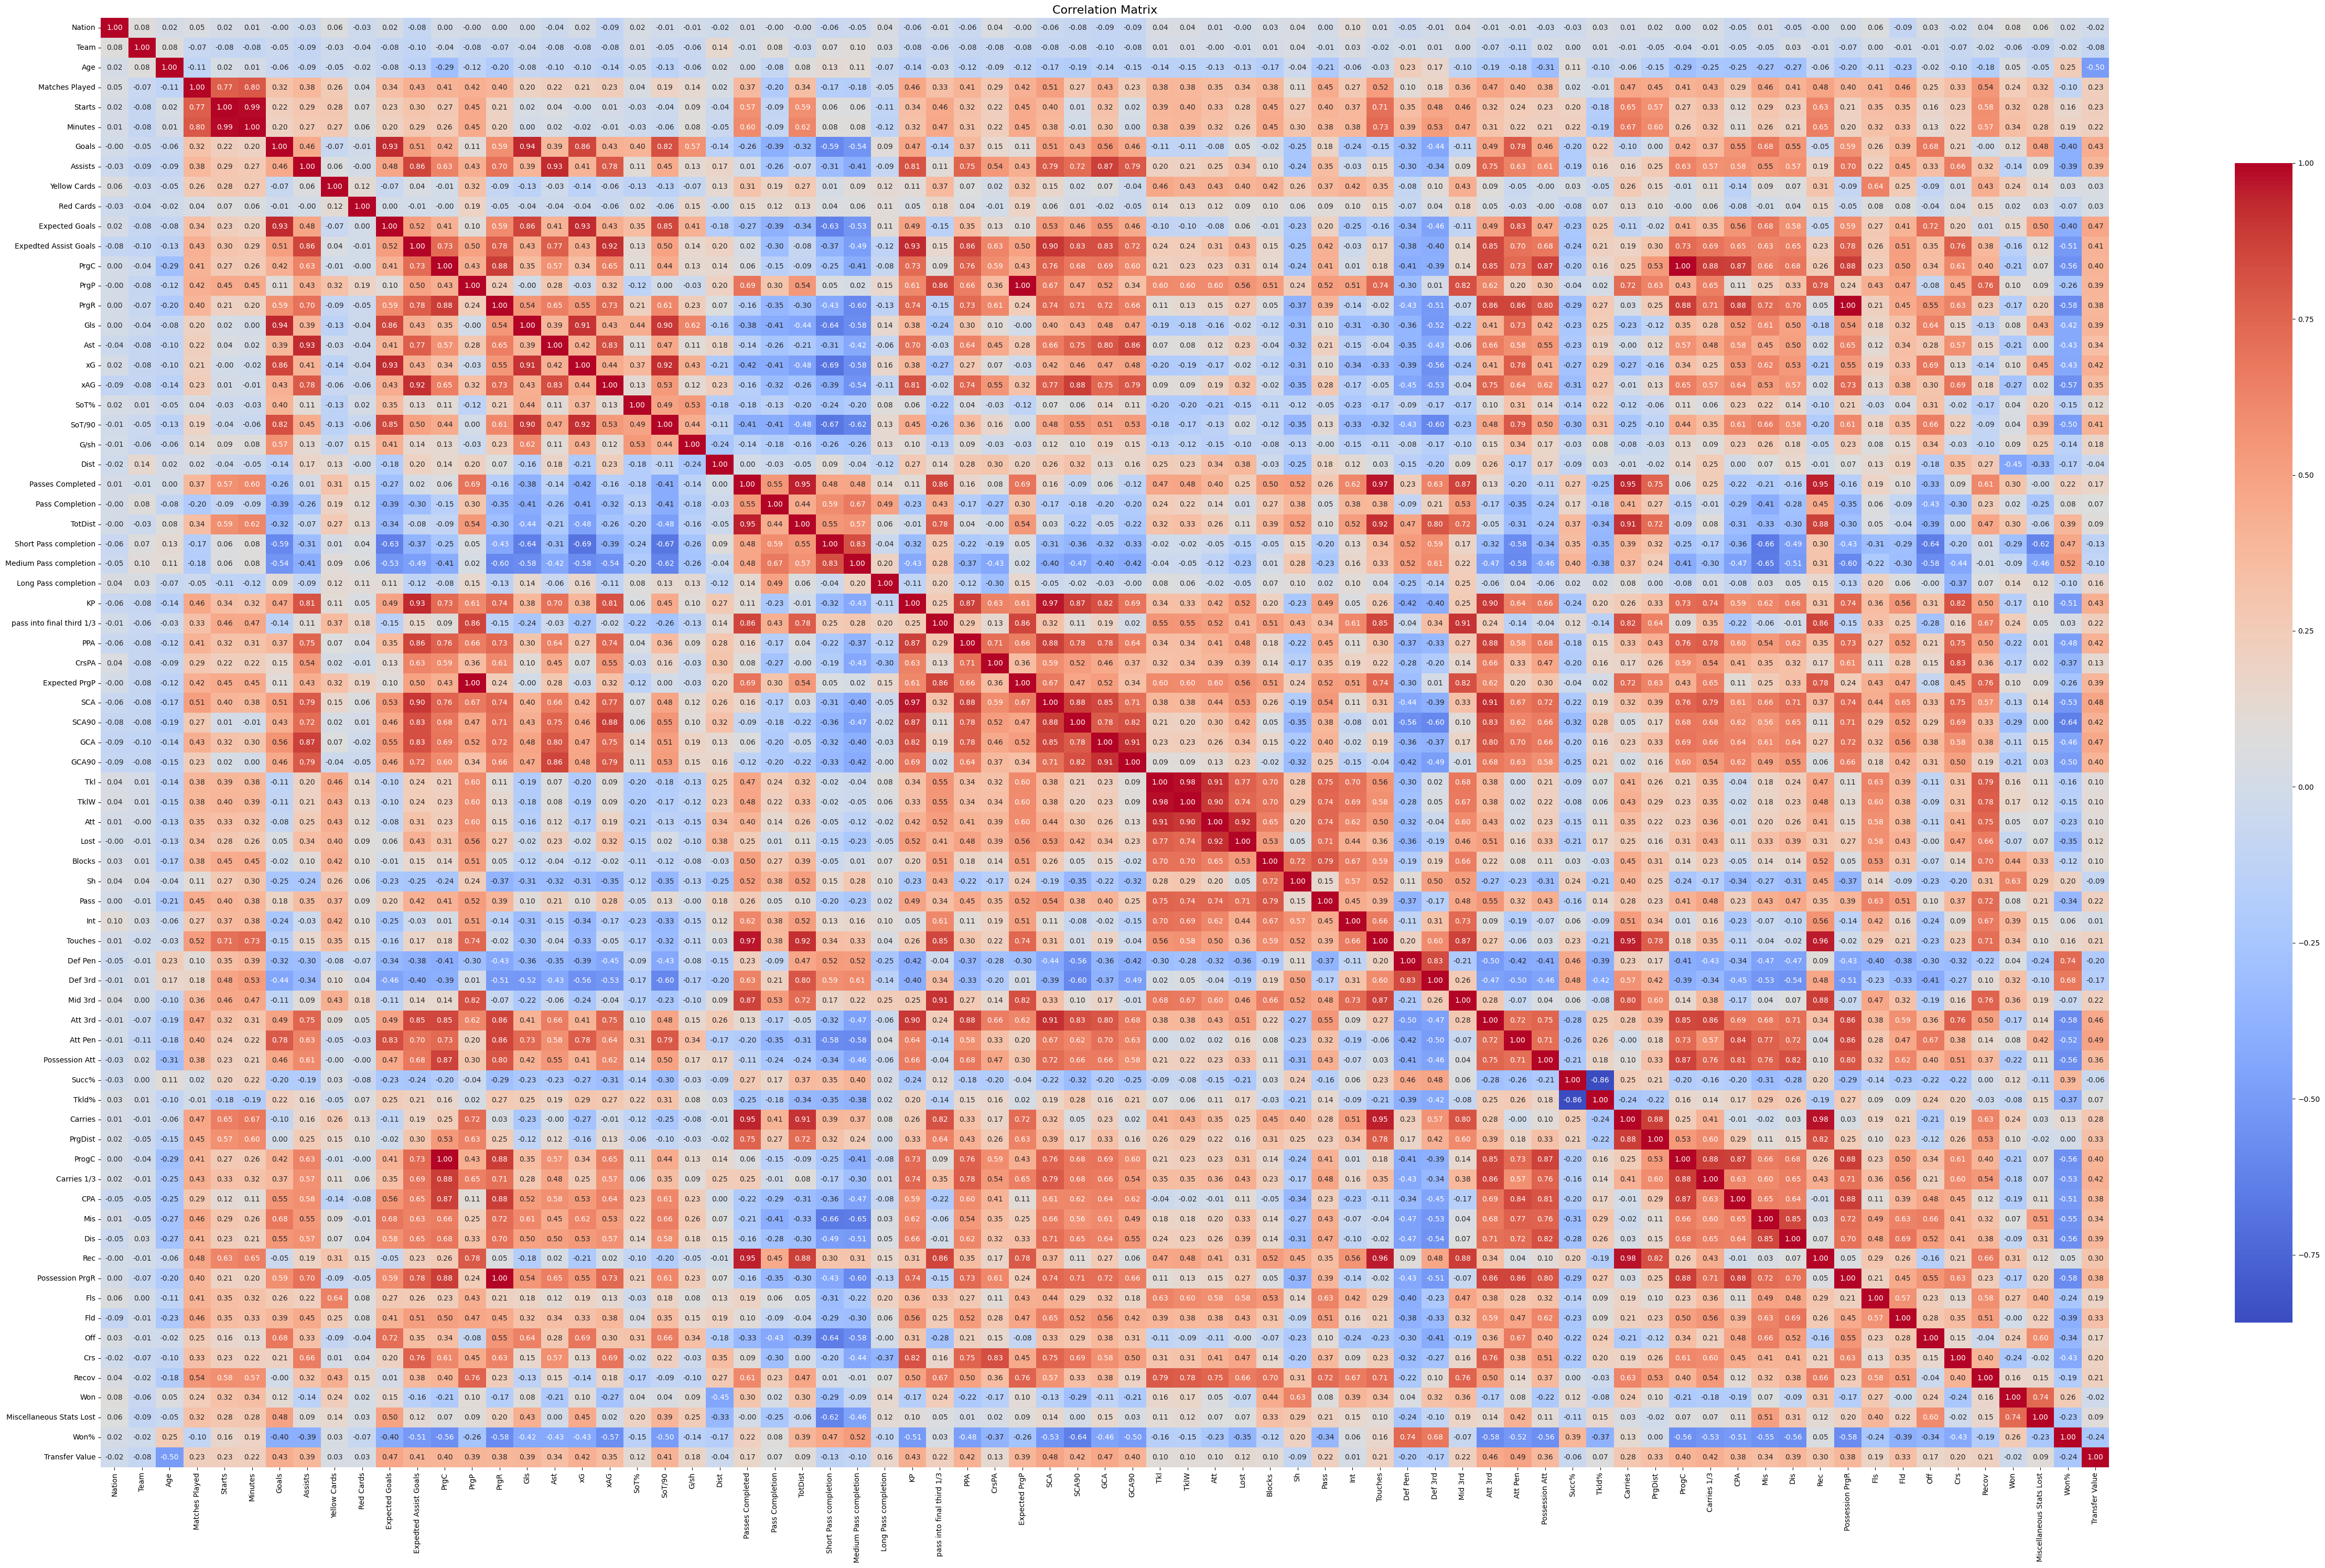

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
corr_matrix = df.corr()

# Create the heatmap for visualization
plt.figure(figsize=(50, 30))  # Adjust the figure size for better layout
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 10}, cbar_kws={'shrink': 0.8})

# Add a title to the plot
plt.title("Correlation Matrix", fontsize=16)

# Adjust layout to prevent clipping
plt.tight_layout()

# Close the plot
plt.show()


# 5. Model building

5.1 Choose important features for train model


In [12]:
# get correlation between each feature and the target 'Transfer Value'
value_corr = corr_matrix['Transfer Value'].drop('Transfer Value')

# select features with a correlation coefficient > 0.2
selected_features = value_corr[abs(value_corr) > 0.2].sort_values(ascending=False)
print("Features strongly correlated with the Transfer Value:")
print(selected_features)

# create a subset of the DataFrame with the selected features
selected_df = df[selected_features.index]

# keep only the upper triangle (to avoid duplicate pairs)
upper_df = selected_df.corr().abs().where( np.triu(np.ones(selected_df.corr().abs().shape), k=1).astype(bool))

# drop highly correlated features (correlation > 0.9)
to_drop = [column for column in upper_df.columns if any(upper_df[column] > 0.9)]
print("Dropped due to high correlation:", to_drop)
selected_df = selected_df.drop(columns=to_drop)

# add the target column back for further analysis
selected_df['Transfer Value'] = df['Transfer Value']

# calculate the absolute correlation coefficients with the target again
cor_coef = selected_df.corr().abs()['Transfer Value'].drop('Transfer Value').sort_values(ascending=False)
print("Correlation Coefficient:\n", cor_coef, sep='')


Features strongly correlated with the Transfer Value:
Att Pen                      0.485937
SCA                          0.481559
Expected Goals               0.470638
GCA                          0.468769
Att 3rd                      0.455969
Goals                        0.434850
KP                           0.432301
xG                           0.421145
Carries 1/3                  0.419437
PPA                          0.418777
SCA90                        0.415004
Expedted Assist Goals        0.410919
SoT/90                       0.409279
GCA90                        0.400538
ProgC                        0.400225
PrgC                         0.400225
Expected PrgP                0.394488
PrgP                         0.394488
Gls                          0.392836
Assists                      0.389306
Dis                          0.387528
PrgR                         0.384031
Possession PrgR              0.384031
CPA                          0.379108
Possession Att               0.361

In [14]:
important_features = cor_coef.index.tolist()
print(important_features)

['Age', 'Att Pen', 'SCA', 'Expected Goals', 'GCA', 'Carries 1/3', 'PPA', 'SCA90', 'ProgC', 'Expected PrgP', 'Assists', 'Dis', 'PrgR', 'CPA', 'Possession Att', 'Mis', 'PrgDist', 'Fld', 'Rec', 'Won%', 'Starts', 'Matches Played', 'pass into final third 1/3', 'Pass', 'Recov', 'Def Pen']


5.2 Split data train and test

In [15]:
df = df[important_features + ['Transfer Value']]
X = df.drop(columns=['Transfer Value'])
y = df['Transfer Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 240
Test set size: 61


5.3 Create model and train

In [16]:
models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(random_state = 42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state = 42)),
    ('KNN', KNeighborsRegressor()),
    ('AdaBoost', AdaBoostRegressor(random_state = 42)),
    ('Decision Tree', DecisionTreeRegressor(random_state = 42))
]

results_list = []
for name, model in models:
    start_time = time.time()
    model.fit(X_train, y_train.values.ravel())
    end_time = time.time()
    train_time = end_time - start_time

    start_time = time.time()
    predictions = model.predict(X_test)
    end_time = time.time()
    prediction_time = end_time - start_time

    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)  
    model_results = {"Model": name,
                    "Train_Score": model.score(X_train, y_train),
                    "Test_Score": model.score(X_test, y_test),
                    "MSE": mse,
                    "RMSE": rmse,
                    "MAE": mae,
                    "Train Time": train_time,
                    "Prediction Time": prediction_time}
    results_list.append(model_results)
results = pd.DataFrame(results_list)
display(results.style.set_table_attributes("style='display:inline'").set_caption('Regression Results'))


,Model,Train_Score,Test_Score,MSE,RMSE,MAE,Train Time,Prediction Time
0,Linear Regression,0.593644,0.726413,191.511434,13.838766,11.671978,0.018907,0.001448
1,Random Forest,0.923188,0.648850,245.805993,15.678201,12.594246,0.353536,0.009108
2,Gradient Boosting,0.966843,0.565439,304.194061,17.441160,13.695321,0.181925,0.010125
3,KNN,0.355491,0.118629,616.961777,24.838715,20.764262,0.001142,0.197435
4,AdaBoost,0.709293,0.458350,379.156088,19.471931,16.656730,0.096389,0.009021
5,Decision Tree,1.000000,0.441946,390.639180,19.764594,14.611475,0.006330,0.001326


In [17]:
# based on Regression Results I think LinearRegression is best model
best_model = LinearRegression()
best_model.fit(X_train, y_train)

LinearRegression()

# 6. Model evaluation

In [19]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Train R²: {train_r2:.2f}")
print(f"Test R²: {test_r2:.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.2f}")

cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print("Cross-validated R² scores:", cv_scores)
print(f"Mean CV R²: {np.mean(cv_scores):.2f}")

Train R²: 0.59
Test R²: 0.73
MAE: 11.67
Cross-validated R² scores: [0.61843055 0.44460644 0.54099377 0.46227747 0.41716326]
Mean CV R²: 0.50


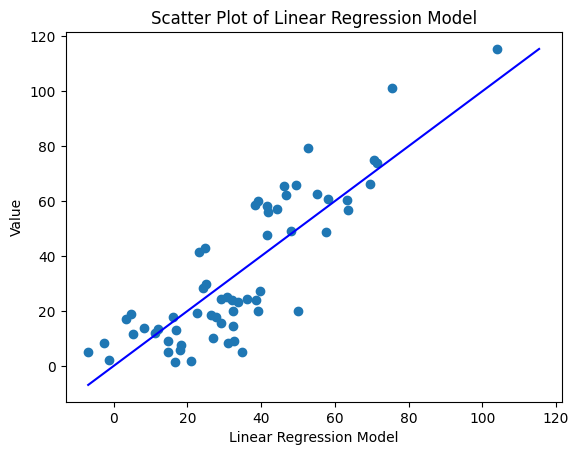

In [22]:
predictions = best_model.predict(X_test)

predictions = np.array(predictions).astype(float)
y_test = np.array(y_test).astype(float)

plt.scatter(predictions, y_test)
plt.xlabel("Linear Regression Model")
plt.ylabel("Value")
plt.title("Scatter Plot of Linear Regression Model")

min_value = min(min(predictions), min(y_test))
max_value = max(max(predictions), max(y_test))

x = np.linspace(min_value, max_value, 100)
y = x
plt.plot(x, y, color='blue', linestyle='solid')

plt.show()


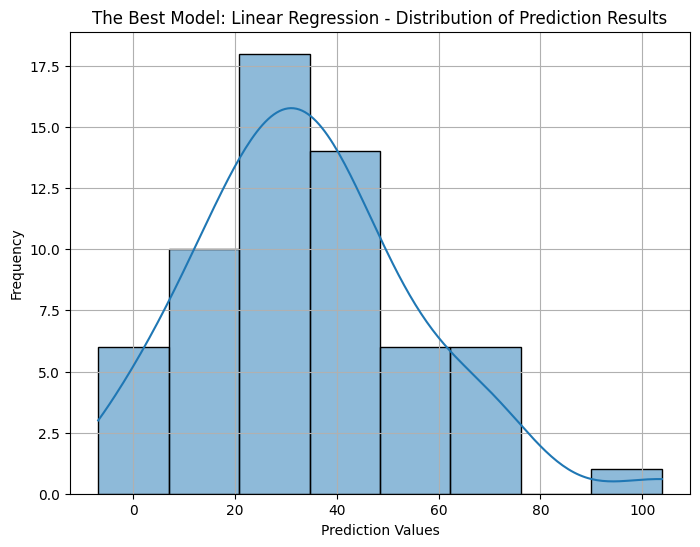

In [23]:
y_test_pred = best_model.predict(X_test)

plt.figure(figsize=(8, 6))
sns.histplot(data=y_test_pred, kde=True)
plt.xlabel('Prediction Values')
plt.ylabel('Frequency')
plt.title(f'The Best Model: Linear Regression - Distribution of Prediction Results')
plt.grid(True)

plt.show()
